In [167]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

In [168]:
date_cols = [
    'Auftragseingang', 
    'Auftragsende_SOLL',
    'AFO_Start_SOLL',
    'AFO_Ende_SOLL',
    'AFO_Start_IST',
    'AFO_Ende_IST'
]

data = pd.read_csv(
    '../data/processed/data_feature_zeit_3_gesamt.csv',
    parse_dates=date_cols,
    sep=',',
    low_memory=False
)

In [169]:
bauteil_map = {
    1: "Steuerventilmodul",
    2: "Schwenkzylinder",
    3: "Daempfungseinheit"
}

maschinen_map = {
    1: "Maschine_A",
    2: "Maschine_B",
    3: "Maschine_C",
    4: "Maschine_D",
    5: "Maschine_E"
}

In [170]:

import pandas as pd

# Bauteil- und Maschinen-Mapping (optional, falls du die Namen brauchst)
bauteil_map = {
    1: "Steuerventilmodul",
    2: "Schwenkzylinder",
    3: "Daempfungseinheit"
}

maschinen_map = {
    1: "Maschine_A",
    2: "Maschine_B",
    3: "Maschine_C",
    4: "Maschine_D",
    5: "Maschine_E"
}

# --- Aggregationsebene: AuftragsID ---
agg_df = (
    data.groupby("AuftragsID")
    .agg({
        # Anzahl Bauteile im Auftrag
        "BauteilID": "count",

        # Zeitliche Eckpunkte des Auftrags
        "Auftragseingang": "min",              # Frühester Eingang
        "Auftragsende_SOLL": "max",            # Spätestes geplantes Ende

        # Priorität aufsummieren (Gesamtdringlichkeit)
        "Priorität": "sum",

        # Prozesskomplexität
        "Arbeitsschritt": "nunique",           # Anzahl unterschiedlicher Arbeitsschritte

        # Maschinen-Einsatz
        "MaschinenID": "nunique",              # Wie viele Maschinen insgesamt beteiligt
        "is_transport_ruesten": "sum",         # Anzahl Transport-/Rüstvorgänge
        "Maschinenkapazität": "mean",          # Durchschnittliche Maschinenkapazität
        "Maschinenkapazität_relativ": "mean",  # Durchschnittliche relative Maschinenkapazität

        # Zeitliche Leistungsdaten
        "AFO_Dauer_SOLL_Stunden": "sum",
        "AFO_Dauer_IST_Stunden": "sum",
        "AFO_Verspätung_Arbeitszeit": "sum",
        "Start_Delay_Arbeitszeit": "sum",
        "End_Delay_Arbeitszeit": "sum",

             "AFO_Ende_IST": "max",
   
        # Prozessstruktur
        "AFO_Erster_Schritt": "min",
        "AFO_Letzter_Schritt": "max",

        # Planungsparameter
        "Wartezeit_vor_Beginn_Tage": "sum",
        "Pufferzeit_geplant_Tage": "sum",
    })
    .reset_index()
)

# -------------------------------------------
# 🔧 Ergänzende, auftragsübergreifende Features
# -------------------------------------------

# 🕓 Datumskomponenten für Auftragseingang
agg_df["auftrags_eingang_tag_num"] = pd.to_datetime(agg_df["Auftragseingang"]).dt.weekday
agg_df["auftrags_eingang_monat"] = pd.to_datetime(agg_df["Auftragseingang"]).dt.month
agg_df["auftrags_eingang_jahr"] = pd.to_datetime(agg_df["Auftragseingang"]).dt.year

# 🕓 Datumskomponenten für geplantes Auftragsende
agg_df["auftrags_ende_tag_num"] = pd.to_datetime(agg_df["Auftragsende_SOLL"]).dt.weekday
agg_df["auftrags_ende_monat"] = pd.to_datetime(agg_df["Auftragsende_SOLL"]).dt.month
agg_df["auftrags_ende_jahr"] = pd.to_datetime(agg_df["Auftragsende_SOLL"]).dt.year

# 🕕 Gesamte geplante Dauer des Auftrags
agg_df["auftrags_geplante_dauer_tage"] = (
    (agg_df["Auftragsende_SOLL"] - agg_df["Auftragseingang"]).dt.total_seconds() / (3600 * 24)
)

agg_df["Lieferabweichung_Stunden"] = (
    (agg_df["AFO_Ende_IST"] - agg_df["Auftragsende_SOLL"]).dt.total_seconds() / 3600
)


# -------------------------------------------
# 🔩 Bauteil-spezifische Häufigkeiten (One-Hot-like Counts)
# -------------------------------------------
# Drei bekannte Bauteiltypen → Zählfeatures
for bid, name in bauteil_map.items():
    agg_df[f"anzahl_{name.lower()}_in_auftrag"] = (
        data.loc[data["BauteilID"] == bid]
        .groupby("AuftragsID")["BauteilID"]
        .count()
        .reindex(agg_df["AuftragsID"], fill_value=0)
        .values
    )

# -------------------------------------------
# 🏭 Maschinen-spezifische Häufigkeiten
# -------------------------------------------
for mid, name in maschinen_map.items():
    agg_df[f"anzahl_{name.lower()}_in_auftrag"] = (
        data.loc[data["MaschinenID"] == mid]
        .groupby("AuftragsID")["MaschinenID"]
        .count()
        .reindex(agg_df["AuftragsID"], fill_value=0)
        .values
    )

# -------------------------------------------
# 🧮 Zusätzliche abgeleitete Features
# -------------------------------------------


# Durchschnittliche Verspätung pro AFO
agg_df["avg_verspaetung_pro_afo"] = (
    agg_df["AFO_Verspätung_Arbeitszeit"] / agg_df["Arbeitsschritt"]
).replace([float("inf"), -float("inf")], 0)
agg_df.drop(columns=["AFO_Verspätung_Arbeitszeit"], inplace=True)




In [171]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156354 entries, 0 to 156353
Data columns (total 36 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   AuftragsID                           156354 non-null  object        
 1   BauteilID                            156354 non-null  int64         
 2   Auftragseingang                      156354 non-null  datetime64[ns]
 3   Auftragsende_SOLL                    156354 non-null  datetime64[ns]
 4   Priorität                            156354 non-null  int64         
 5   Arbeitsschritt                       156354 non-null  int64         
 6   MaschinenID                          156354 non-null  int64         
 7   is_transport_ruesten                 156354 non-null  int64         
 8   Maschinenkapazität                   156306 non-null  float64       
 9   Maschinenkapazität_relativ           156306 non-null  float64       
 

In [172]:
agg_df.head()

,AuftragsID,BauteilID,Auftragseingang,Auftragsende_SOLL,Priorität,Arbeitsschritt,MaschinenID,is_transport_ruesten,Maschinenkapazität,Maschinenkapazität_relativ,...,Lieferabweichung_Stunden,anzahl_steuerventilmodul_in_auftrag,anzahl_schwenkzylinder_in_auftrag,anzahl_daempfungseinheit_in_auftrag,anzahl_maschine_a_in_auftrag,anzahl_maschine_b_in_auftrag,anzahl_maschine_c_in_auftrag,anzahl_maschine_d_in_auftrag,anzahl_maschine_e_in_auftrag,avg_verspaetung_pro_afo
0,00003d034e774fd2bc02af8c8189ba3c,9,2017-09-01,2017-09-06 08:12:00,27,6,3,4,17.000000,1.000000,...,-19.266667,9,0,0,1,1,1,0,0,-0.672222
1,0000fb9edd6e4ca58ede2de57128cee9,11,2020-12-05,2021-03-04 08:02:00,33,7,4,5,14.250000,0.980000,...,-192.083333,0,11,0,1,1,1,1,0,-7.240476
2,00018480055047c1bee9fe8e8f3cd2ab,9,2022-11-22,2023-02-22 08:52:00,9,6,3,4,15.666667,0.946667,...,7059.750000,9,0,0,1,1,1,0,0,-3.450000
3,0001c15473734e9aacfa7513e0d33485,7,2021-09-09,2021-12-21 10:12:00,7,5,2,3,15.500000,0.960000,...,20.933333,0,0,7,0,1,0,1,0,0.096667
4,00021580f3c74c62b99dba124d17835e,11,2019-06-28,2019-09-10 13:22:00,22,7,4,5,13.500000,0.950000,...,18.566667,0,11,0,1,1,1,1,0,0.054762


In [173]:
agg_df['Anzahl_Bauteile_im_Auftrag'] = agg_df['BauteilID']
agg_df.drop(columns=['BauteilID'], inplace=True)
agg_df.drop(columns=['Auftragseingang'], inplace=True)
agg_df.drop(columns=['Auftragsende_SOLL'], inplace=True)
agg_df['Priorität_insgesamt'] = agg_df['Priorität']
agg_df.drop(columns=['Priorität'], inplace=True)
agg_df['Beteiligte_Maschinen_Anzahl'] = agg_df['MaschinenID']
agg_df.drop(columns=['MaschinenID'], inplace=True)
agg_df.drop(['AFO_Dauer_SOLL_Stunden', 'AFO_Dauer_IST_Stunden'], axis=1)
agg_df.drop(columns=['AuftragsID'], inplace=True)
agg_df['Auftrag_SOLL_Stunden'] = agg_df['AFO_Dauer_SOLL_Stunden']
agg_df.drop(columns=['AFO_Dauer_SOLL_Stunden'], inplace=True)
agg_df['Auftrag_IST_Stunden'] = agg_df['AFO_Dauer_IST_Stunden']
agg_df.drop(columns=['AFO_Dauer_IST_Stunden'], inplace=True)
agg_df.drop(columns=['AFO_Ende_IST'], inplace=True)
agg_df.drop(columns=['Start_Delay_Arbeitszeit'], inplace=True)
agg_df.drop(columns=['End_Delay_Arbeitszeit'], inplace=True)
agg_df.drop(columns=['Wartezeit_vor_Beginn_Tage'], inplace=True)
agg_df.drop(columns=['Pufferzeit_geplant_Tage'], inplace=True)
agg_df.drop(columns=['avg_verspaetung_pro_afo'], inplace=True)




In [174]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156354 entries, 0 to 156353
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Arbeitsschritt                       156354 non-null  int64  
 1   is_transport_ruesten                 156354 non-null  int64  
 2   Maschinenkapazität                   156306 non-null  float64
 3   Maschinenkapazität_relativ           156306 non-null  float64
 4   AFO_Erster_Schritt                   156354 non-null  int64  
 5   AFO_Letzter_Schritt                  156354 non-null  int64  
 6   auftrags_eingang_tag_num             156354 non-null  int32  
 7   auftrags_eingang_monat               156354 non-null  int32  
 8   auftrags_eingang_jahr                156354 non-null  int32  
 9   auftrags_ende_tag_num                156354 non-null  int32  
 10  auftrags_ende_monat                  156354 non-null  int32  
 11  auftrags_ende

In [175]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156354 entries, 0 to 156353
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Arbeitsschritt                       156354 non-null  int64  
 1   is_transport_ruesten                 156354 non-null  int64  
 2   Maschinenkapazität                   156306 non-null  float64
 3   Maschinenkapazität_relativ           156306 non-null  float64
 4   AFO_Erster_Schritt                   156354 non-null  int64  
 5   AFO_Letzter_Schritt                  156354 non-null  int64  
 6   auftrags_eingang_tag_num             156354 non-null  int32  
 7   auftrags_eingang_monat               156354 non-null  int32  
 8   auftrags_eingang_jahr                156354 non-null  int32  
 9   auftrags_ende_tag_num                156354 non-null  int32  
 10  auftrags_ende_monat                  156354 non-null  int32  
 11  auftrags_ende

/var/folders/mc/jb1nbgjx243512nh0dbf14km0000gn/T/ipykernel_12407/3580088165.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


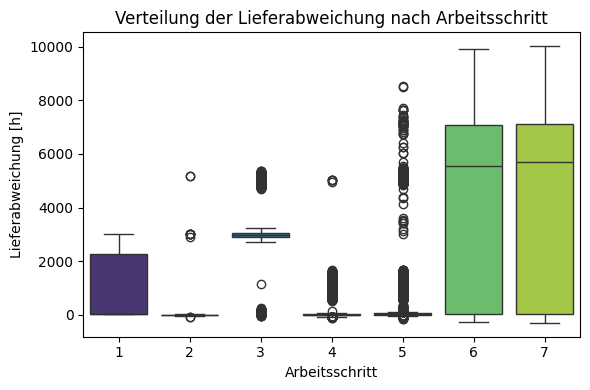

/var/folders/mc/jb1nbgjx243512nh0dbf14km0000gn/T/ipykernel_12407/3580088165.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


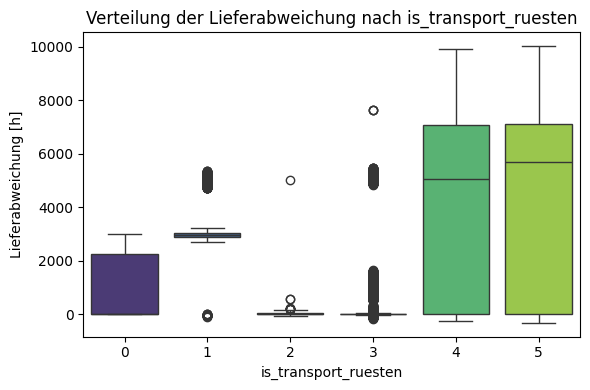

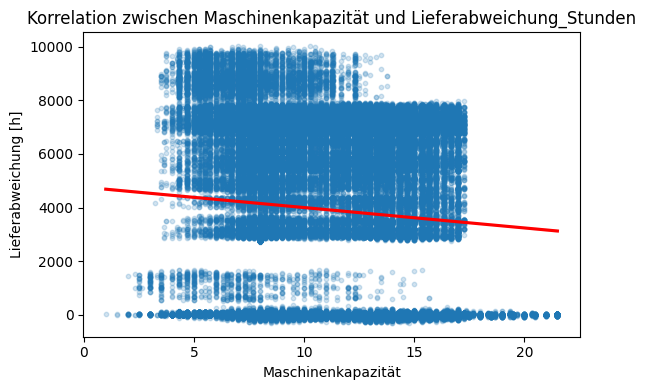

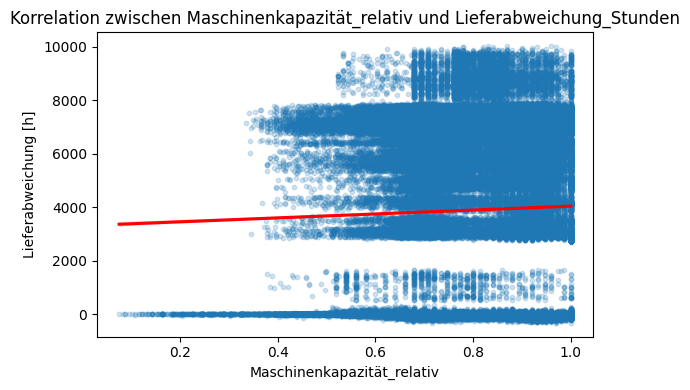

KeyError: 'Start_Delay_Arbeitszeit'

<Figure size 600x400 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===============================
# 🎯 Zielvariable
# ===============================
target = "Lieferabweichung_Stunden"

# ===============================
# 🔍 Alle Feature-Spalten
# ===============================
features = [
    "Arbeitsschritt", "is_transport_ruesten", "Maschinenkapazität", "Maschinenkapazität_relativ", "AFO_Erster_Schritt", "AFO_Letzter_Schritt", "auftrags_eingang_tag_num",
    "auftrags_eingang_monat", "auftrags_eingang_jahr", "auftrags_ende_tag_num", "auftrags_ende_monat",
    "auftrags_ende_jahr", "auftrags_geplante_dauer_tage", "anzahl_steuerventilmodul_in_auftrag",
    "anzahl_schwenkzylinder_in_auftrag", "anzahl_daempfungseinheit_in_auftrag",
    "anzahl_maschine_a_in_auftrag", "anzahl_maschine_b_in_auftrag", "anzahl_maschine_c_in_auftrag",
    "anzahl_maschine_d_in_auftrag", "anzahl_maschine_e_in_auftrag", 
    "Anzahl_Bauteile_im_Auftrag", "Priorität_insgesamt", "Beteiligte_Maschinen_Anzahl",
    "Auftrag_SOLL_Stunden", "Auftrag_IST_Stunden"
]

# ===============================
# 📊 Automatische Plot-Erstellung
# ===============================
for col in features:
    plt.figure(figsize=(6, 4))
    
    # 🔢 Numerische Werte → Regressionsplot
    if agg_df[col].nunique() > 10:
        sns.regplot(
            data=agg_df, x=col, y=target,
            scatter_kws={'alpha': 0.2, 's': 10}, line_kws={"color": "red"}
        )
        plt.title(f"Korrelation zwischen {col} und {target}")
        plt.xlabel(col)
        plt.ylabel("Lieferabweichung [h]")
    
    # 🔠 Diskrete Werte → Boxplot
    else:
        sns.boxplot(
            data=agg_df, x=col, y=target, palette="viridis"
        )
        plt.title(f"Verteilung der Lieferabweichung nach {col}")
        plt.xlabel(col)
        plt.ylabel("Lieferabweichung [h]")

    plt.tight_layout()
    plt.show()


In [ ]:
print(agg_df["Arbeitsschritt"].unique())


[6 7 5 4 3 2 1]


📊 Korrelationen mit Lieferabweichung_Stunden:

Lieferabweichung_Stunden               1.000000
Start_Delay_Arbeitszeit                0.985783
End_Delay_Arbeitszeit                  0.985701
Wartezeit_vor_Beginn_Tage              0.613487
anzahl_maschine_c_in_auftrag           0.385466
AFO_Letzter_Schritt                    0.277678
Arbeitsschritt                         0.246235
Anzahl_Bauteile_im_Auftrag             0.231439
Beteiligte_Maschinen_Anzahl            0.225543
is_transport_ruesten                   0.209640
Auftrag_IST_Stunden                    0.188200
anzahl_maschine_e_in_auftrag           0.130408
anzahl_schwenkzylinder_in_auftrag      0.080734
anzahl_steuerventilmodul_in_auftrag    0.071317
Pufferzeit_geplant_Tage                0.062405
anzahl_maschine_a_in_auftrag           0.060256
Auftrag_SOLL_Stunden                   0.048738
Maschinenkapazität_relativ             0.029984
auftrags_ende_jahr                     0.027234
auftrags_eingang_jahr                  0.

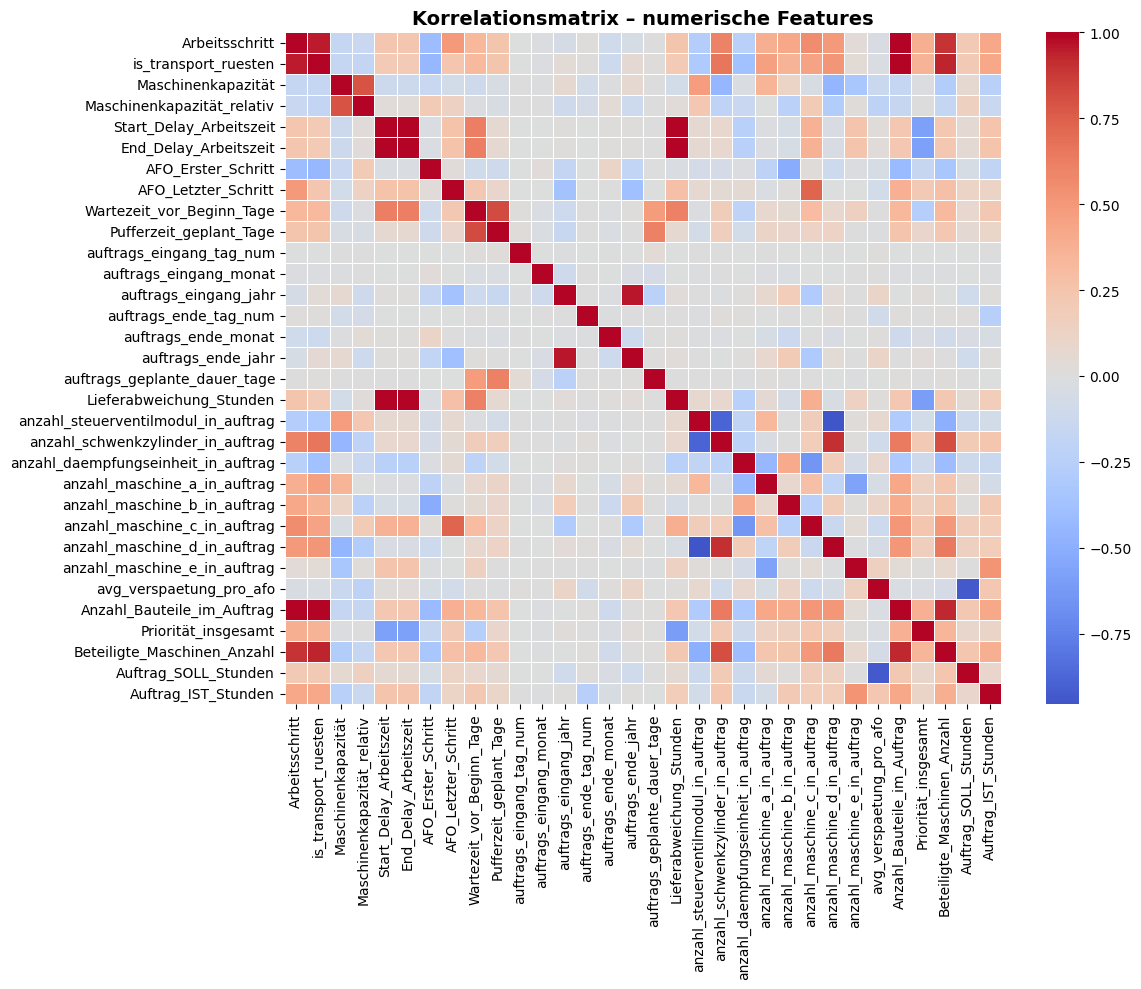

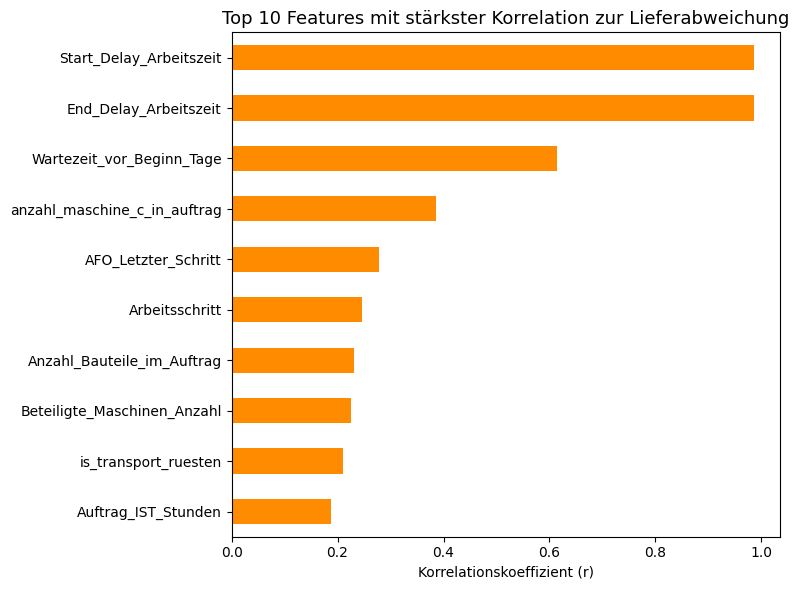

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===============================
# 🔍 Korrelationen berechnen
# ===============================
corr = agg_df.corr(numeric_only=True)

# Fokus: Nur Korrelationen mit der Zielvariable
target_corr = corr["Lieferabweichung_Stunden"].sort_values(ascending=False)

print("📊 Korrelationen mit Lieferabweichung_Stunden:\n")
print(target_corr)

# ===============================
# 🎨 Heatmap zeichnen
# ===============================
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    center=0,
    linewidths=0.5
)
plt.title("Korrelationsmatrix – numerische Features", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# ===============================
# 🎯 Top 10 Einflussfaktoren (nach Korrelation)
# ===============================
plt.figure(figsize=(8,6))
target_corr.drop("Lieferabweichung_Stunden").head(10).plot(kind="barh", color="darkorange")
plt.gca().invert_yaxis()
plt.title("Top 10 Features mit stärkster Korrelation zur Lieferabweichung", fontsize=13)
plt.xlabel("Korrelationskoeffizient (r)")
plt.tight_layout()
plt.show()


In [ ]:
agg_df.to_csv('../data/processed/auftrag_gesamt_features.csv', index=False)